# Effect of transforming the targets in regression model
- 선형 회귀 모델을 학습하기 전에 대상을 변환할 때의 이점을 설명

## Stnthetic example

In [1]:
import numpy as np

from sklearn.datasets import make_regression

X, y = make_regression(n_samples=10_000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

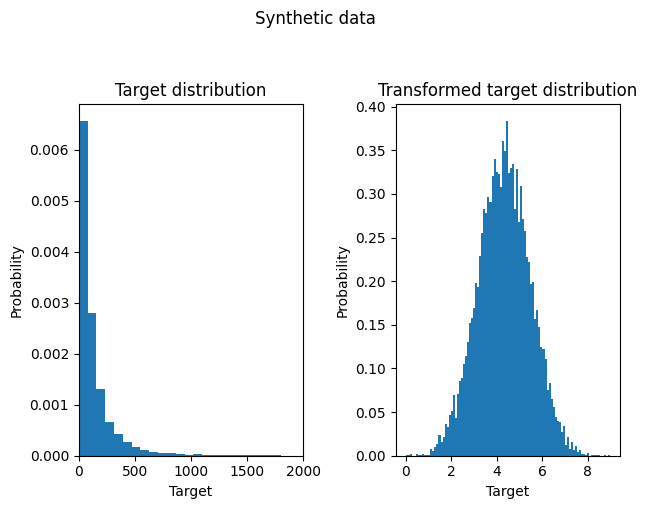

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 2000])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
from sklearn.metrics import median_absolute_error, r2_score


def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

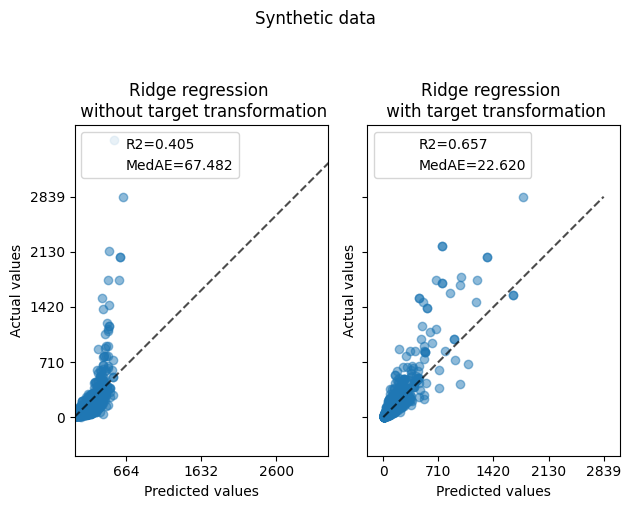

In [4]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# 각 축의 레전드에 점수를 추가
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

## Real-world data set

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import quantile_transform

ames = fetch_openml(name="house_prices", as_frame=True)
# 숫자 열만 유지
X = ames.data.select_dtypes(np.number)
# NaN 또는 Inf 값이 있는 열 제거
X = X.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"])
# 가격을 k$로 설정
y = ames.target / 1000
y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


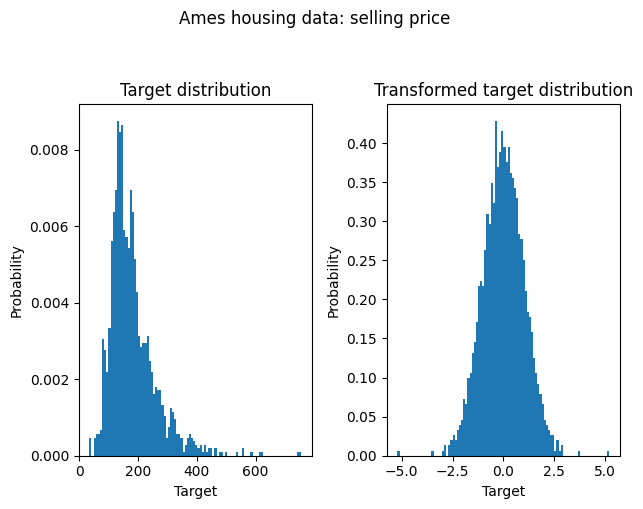

In [6]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()